In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from collections import Counter

/var/folders/36/xfvf6zw53bd2ht35p52k28qh0000gn/T/ipykernel_10172/3380512585.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[target] = df_filtered[target].map({1: 1, 2: 0})
/var/folders/36/xfvf6zw53bd2ht35p52k28qh0000gn/T/ipykernel_10172/3380512585.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.drop(columns=[col for col in drop_cols if col in df_filtered.columns], inplace=True)
/var/folders/36/xfvf6zw53bd2ht35p52k28qh0000gn/T/ipykernel_10172/3380512585.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

Model Accuracy: 0.9643

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.61      0.76        57
         1.0       0.96      1.00      0.98       559

    accuracy                           0.96       616
   macro avg       0.98      0.81      0.87       616
weighted avg       0.97      0.96      0.96       616



/var/folders/36/xfvf6zw53bd2ht35p52k28qh0000gn/T/ipykernel_10172/3380512585.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feature_importances, palette="viridis")


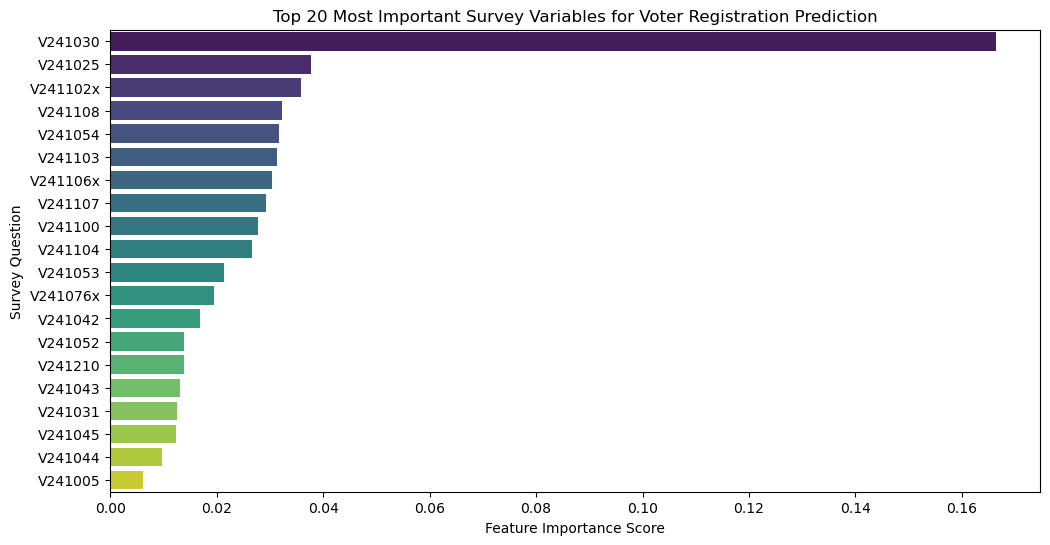

In [2]:
# Load dataset
file_path = "anes/anes_timeseries_2024_csv_20250219.csv"  # Change path if necessary
df = pd.read_csv(file_path, low_memory=False)

# Select the target variable: "Is R registered to vote?" (V241012)
target = "V241012"

# Remove rows with missing/invalid responses in the target (-1, -8, -9 indicate missing/refused)
df_filtered = df[~df[target].isin([-1, -8, -9])]

# Convert target to binary (1 = Registered, 0 = Not Registered)
df_filtered[target] = df_filtered[target].map({1: 1, 2: 0})

# Drop non-informative columns (IDs, version, sample type, weights)
drop_cols = ["version", "V240001", "V200001", "V160001_orig", "V240002", "V240003"] + \
            [col for col in df_filtered.columns if "_a" in col or "_c" in col or "_d" in col]  # Weight variables

df_filtered.drop(columns=[col for col in drop_cols if col in df_filtered.columns], inplace=True)

# Identify categorical and numerical columns
categorical_cols = df_filtered.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df_filtered.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Encode categorical variables
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_filtered[col] = le.fit_transform(df_filtered[col].astype(str))
    label_encoders[col] = le

# Handle missing values using median imputation
imputer = SimpleImputer(strategy="median")
df_filtered[numerical_cols] = imputer.fit_transform(df_filtered[numerical_cols])

# Define features (X) and target (y)
X = df_filtered.drop(columns=[target])
y = df_filtered[target]

# Split into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train a balanced Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Model Evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Feature Importance Analysis
feature_importances = pd.DataFrame({"Feature": X.columns, "Importance": rf_model.feature_importances_})
feature_importances = feature_importances.sort_values(by="Importance", ascending=False).head(20)

# Plot Feature Importance
plt.figure(figsize=(12, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importances, palette="viridis")
plt.xlabel("Feature Importance Score")
plt.ylabel("Survey Question")
plt.title("Top 20 Most Important Survey Variables for Voter Registration Prediction")
plt.show()